In [2]:
from anytree import NodeMixin, RenderTree
import numpy as np
from pysam import VariantFile, FastaFile
from anytree import find_by_attr, PreOrderIter
import json

In [3]:
class Node(NodeMixin):
    def __init__(self, name, snps=[],insertion=[],deletion = [], parent=None, children=None):
        self.name = name
        self.snps = snps
        self.insertion = insertion
        self.deletion = deletion
        self.parent = parent
        self.lh = 0
        if children:  # set children only if given
             self.children = children
    
    def __repr__(self):
             return self.name +" "+ str(self.lh)
    def __str__(self):
        return self.name

In [4]:
def get_snp(node):
    '''
    Returns snps fron node: Node
    
    Paramters:
    node : Node
    node in phylogenetic tree
    
    Returns:
    list of lists of [old_nucleotide,new_nucleotid, position]
    '''
    snp = list()
    atgc = set(['A','T','G','C','a','t','g','c'])
    for i in range(2,len(node)):
        if node[i][0] in atgc and node[i][-1] in atgc:
            snp.append([node[i][0],node[i][-1],int(node[i][1:-1])])
    return snp

In [5]:
def get_insertion(node):
    '''
    Currently unused
    '''
    ins = set()
    for i in range(2,len(node)):
        if '.' in node[i]:
            dot_pos = node[i].find('.')
            pos = int(node[i][1:dot_pos])
#             size = ''.join(k for k in node[i][dot_pos+1:] if  k.isdigit())
#             insert = ''.join(k for k in node[i][dot_pos+1:] if  k.isalpha())
            ins.add(pos)
    return ins

In [6]:
def get_deletion(node):
    '''
    Currently unused
    '''
    deletion = set()
    for i in range(2,len(node)):
        if node[i][-1]=='d':
            if node[i][0].isalpha():
                deletion.add(int(node[i][1:-1]))
            else:
                dash_pos = node[i].find('-')
                deletion.add(int(node[i][1:dash_pos]))
    return deletion

In [7]:
def make_tree(tree,node,pos=0):    
    '''
    Initializate tree structure of phylogenetic tree
    Parameters:
    tree: list
    list from phylotree-parse
    node: Node
    root node
    pos: int
    unnecessary parameter. position of current node in tree list
    
    '''

    
    posit = pos + 1
    i = posit
    while i<len(tree) and tree[i][0] >= tree[pos][0]+1:
        if tree[i][0] == tree[pos][0]+1:
            # print(node.name,tree[i][1])
            snps = get_snp(tree[i])
            # insertion = get_insertion(tree[i])
            insertion = set()
            # deletion = get_deletion(tree[i])
            deletion = set()
            tmp = Node(tree[i][1],snps,insertion,parent=node)
            
            make_tree(tree,tmp,i)

        i += 1        

In [44]:
def get_log_monozygous(bcf: VariantFile):
    '''
    PL scores for bcf
    
    '''
    gls = np.full((16569,4),-1)
    for rec in bcf.fetch():
        pos = rec.pos
        pls = rec.samples.values()[0]['PL']
        alt = rec.alleles
        k = 0
        s = 2
        for i in range(len(alt)):
            if alt[i] == 'A':
                gls[pos-1][0] = pls[k]
            elif alt[i] == 'T':
                gls[pos-1][1] = pls[k]
            elif alt[i] == 'G':
                gls[pos-1][2] = pls[k]
            elif alt[i] == 'C':
                gls[pos-1][3] = pls[k]
            elif alt[i] == '<*>':
                for j in range(4):
                    if gls[pos-1][j] == -1:
                        gls[pos-1][j] = pls[k]
            k += s
            s += 1
    return gls

In [33]:
def call_likelihood(gls,node,ref,lh=0):
    '''
    Calculates likelihood for node considering parent node likelihood.
    
    Parameters:
    gls : np.array
    array of snp likelihoods
    node: Node
    haplogroup node
    ref: FastaFile
    reference genome
    lh: float
    genotype likelihood for parent haplogroup
    
    Returns
    
    lh : float
    likelihood of haplogroup
    '''
    snps = node.snps
    for snp in snps:
#       snp = [old, new, pos]
        pos = snp[2]-1
        if snp[1].capitalize() == 'A':
            lh = lh - calculate_pl(gls,ref, pos) + gls[pos,0]
        if snp[1].capitalize() == 'T':
            lh = lh - calculate_pl(gls,ref, pos) + gls[pos,1]
        if snp[1].capitalize() == 'G':
            lh = lh - calculate_pl(gls,ref, pos) + gls[pos,2]
        if snp[1].capitalize() == 'C':
            lh = lh - calculate_pl(gls,ref, pos) + gls[pos,3]
        
    
#         for ins in insertions:
#             if ins[0] in node.insertion:
#             ins = [pos,lh]
#                 pos = ins[0]-1
#                 lh = lh - calculate_pl(gls,ref,pos) + lh[1]

#         for delt in deletions:
#             if ins[0] in node.deletion:
#             delt = [pos,lh]
#                 pos = delt[0]-1
#                 lh = lh - calculate_pl(gls,ref,pos) + delt[1]
    return lh
        
    
    

In [21]:
def calculate_likelihood(vcf, ref):
    '''
    Calculates genotype likelihood against reference genome
    
    
    Parameters:
    -----------
    vcf : VariantFile
    vcf/bcf file
    
    ref: FastaFile
    reference genome
    --
    Returns
    -------
    lh : float
    likelihood against reference
    '''
    lh = 0
    ref = ref.fetch('chrM')
    gls = get_log_monozygous(vcf)
    for i in range(len(ref)):
        if ref[i].capitalize() == 'A':
            lh += gls[i,0]
        if ref[i].capitalize() == 'T':
            lh += gls[i,1]
        if ref[i].capitalize() == 'G':
            lh += gls[i,2]
        if ref[i].capitalize() == 'C':
            lh += gls[i,3]
    return lh

In [34]:
def prunung(node, ref, ref_lh, gls):
    '''
    Calculates genotype likelihood for each haplogroup in the tree
    Parameters:
    -----------
    node: Node
    root node in the tree structure
    ref: FastaFile
    reference file
    gls: np.array
    matrix of snp pl scores
    '''
    if node.parent == None:
        node.lh = ref_lh
    else:
        node.lh = call_likelihood(gls,node,ref,node.parent.lh)
    for i in node.children:
        prunung(i,ref, ref_lh, gls)

In [35]:
def calculate_pl(gls, ref, pos):
    '''
    Calculate pl score of certain position on reference
    
    Parameters:
    -----------
    gls : np.array
    matrix of snp pl scores
    ref: FastaFile
    reference
    pos: int
    position
    '''
    lh = 0
    ref = ref.fetch('chrM')
    i = pos
    if ref[i].capitalize() == 'A':
        lh += gls[i,0]
    if ref[i].capitalize() == 'T':
        lh += gls[i,1]
    if ref[i].capitalize() == 'G':
        lh += gls[i,2]
    if ref[i].capitalize() == 'C':
        lh += gls[i,3]
    return lh

In [83]:
# import argparse
# parser = argparse.ArgumentParser(description='Calculation of haplogroups')
# parser.add_argument('tree', type=str, help='haplogroup tree')
# parser.add_argument('ref', type=str, help='reference fasta')
# parser.add_argument('vcf', type=str, help='vcf file of mtdna')
# args = parser.parse_args()

In [84]:

# with open(args.tree) as f:
#     d = json.load(f) # d - это список python
# #     print(d)
# for i in d:
#     i[0] += 1
#     d[0][0]=0

# bcf_in = VariantFile(args.vcf) 
# ref = FastaFile(args.ref)


In [36]:
def glhap(bcf_in_str, comment=True):
    with open('array/array.json') as f:
        d = json.load(f) # d - это список python
    for i in d:
        i[0] += 1
    d[0][0]=0

    bcf_in = VariantFile(bcf_in_str) 
    ref = FastaFile('refchrm.fa')
    a = Node(d[0][1],[])
    make_tree(d,a,0)
    ref_lh = calculate_likelihood(bcf_in, ref)
    gls = get_log_monozygous(bcf_in)
    prunung(a, ref, ref_lh, gls)
    key = lambda x: x.lh
    S = list()
    for i in PreOrderIter(a):
        S.append(i)
    S.sort(key = key,reverse=False)
    if comment:
        for i in range(10):
            print(S[i].name+",lh = ",S[i].lh)
    
    # print(ref_lh)
    return [(S[i].name, S[i].lh) for i in range(10)]

In [25]:
  ref = FastaFile('refchrm.fa')

In [15]:
# calculate_likelihood(bcf_test, ref)

NameError: name 'bcf_test' is not defined

In [45]:
glhap("gargammelhigh.vcf")

L2d1a,lh =  11564
L2d1,lh =  11857
L2d,lh =  11941
-,lh =  11941
L2b'c'd,lh =  13983
L2a'b'c'd,lh =  14094
L2,lh =  14140
L2a,lh =  14349
H5'36,lh =  14490
HV8,lh =  14651


[('L2d1a', 11564),
 ('L2d1', 11857),
 ('L2d', 11941),
 ('-', 11941),
 ("L2b'c'd", 13983),
 ("L2a'b'c'd", 14094),
 ('L2', 14140),
 ('L2a', 14349),
 ("H5'36", 14490),
 ('HV8', 14651)]

In [46]:
glhap("gargammellow.vcf")

L2d1,lh =  13762
L2d1a,lh =  13762
L2d,lh =  13871
-,lh =  13871
L2b'c'd,lh =  14540
L2a'b'c'd,lh =  14666
L2,lh =  14794
mt-MRCA (RSRS),lh =  14910
L1'2'3'4'5'6,lh =  14910
L2'3'4'5'6,lh =  14910


[('L2d1', 13762),
 ('L2d1a', 13762),
 ('L2d', 13871),
 ('-', 13871),
 ("L2b'c'd", 14540),
 ("L2a'b'c'd", 14666),
 ('L2', 14794),
 ('mt-MRCA (RSRS)', 14910),
 ("L1'2'3'4'5'6", 14910),
 ("L2'3'4'5'6", 14910)]

In [17]:
 bcf_in = VariantFile("gargammel1.vcf") 
ref = FastaFile('refchrm.fa')
calculate_likelihood(bcf_in, ref)

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_3976/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_3976/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_3976/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_3976/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)


-330180

In [152]:
get_log_monozygous(bcf_in)[16128]

array([255, 255,   0, 255])

In [178]:
f = open('rsrs.fasta', 'r')

In [179]:
s = ''.join(f.readlines()[1:]).replace('\n','')

In [187]:
s[73-1]

'A'

In [18]:
glhap("gargammelhigh.vcf")

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_3976/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_3976/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_3976/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_3976/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_3976/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


L2d,lh =  -330240
-,lh =  -330240
L2d1,lh =  -330240
L2d1a,lh =  -330240
L2,lh =  -330220
L2a'b'c'd,lh =  -330220
L2b'c'd,lh =  -330220
L2a,lh =  -330200
H5'36,lh =  -330200
mt-MRCA (RSRS),lh =  -330180


[('L2d', -330240),
 ('-', -330240),
 ('L2d1', -330240),
 ('L2d1a', -330240),
 ('L2', -330220),
 ("L2a'b'c'd", -330220),
 ("L2b'c'd", -330220),
 ('L2a', -330200),
 ("H5'36", -330200),
 ('mt-MRCA (RSRS)', -330180)]

In [ ]:
for i in range(1,13):
    info = glhap("gargammel12.vcf")
    y_vec = [x[1] for x in info]
    plt.plot
    

In [77]:
v = glhap("gargammel1.vcf")

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/4031268679.py:19: RuntimeWarning: divide by zero encountered in log
  gls[pos-1][2] = max(np.log(1- 10**(-pls[k]/10)),-255)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/4031268679.py:15: RuntimeWarning: divide by zero encountered in log
  gls[pos-1][0] = max(np.log(1- 10**(-pls[k]/10)),-255)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/4031268679.py:17: RuntimeWarning: divide by zero encountered in log
  gls[pos-1][1] = max(np.log(1- 10**(-pls[k]/10)),-255)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/4031268679.py:21: RuntimeWarning: divide by zero encountered in log
  gls[pos-1][3] = max(np.log(1- 10**(-pls[k]/10)),-255)


L2d,lh =  -4210050
-,lh =  -4210050
L2d1,lh =  -4210050
H5'36,lh =  -4210050
mt-MRCA (RSRS),lh =  -4209795
L1'2'3'4'5'6,lh =  -4209795
L2'3'4'5'6,lh =  -4209795
L2'3'4'6,lh =  -4209795
L2,lh =  -4209795
L2a'b'c'd,lh =  -4209795


In [48]:
import matplotlib.pyplot as plt

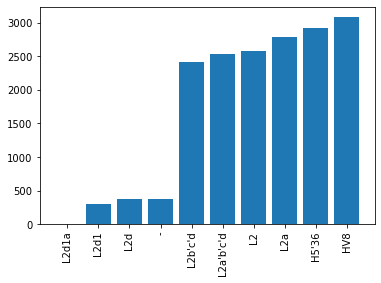

In [51]:
v = glhap(f"gargammelhigh.vcf", False)
x = [s[0] for s in v]
y = np.array([s[1] for s in v])
plt.bar(x,y-y.min())
plt.xticks(rotation=90)
plt.show()

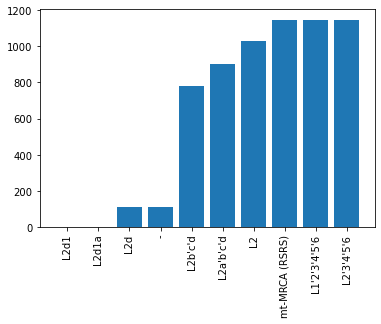

In [54]:
v = glhap(f"gargammellow.vcf", False)
x = [s[0] for s in v]
y = np.array([s[1] for s in v])
plt.bar(x,y-y.min())
plt.xticks(rotation=90)
plt.show()

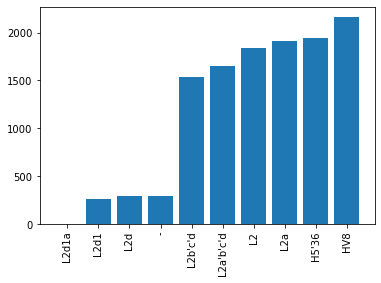

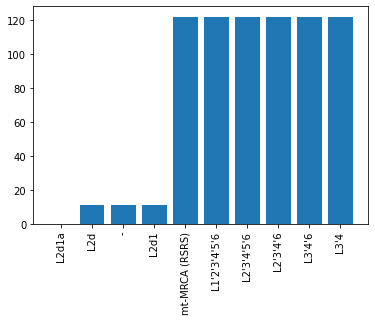

In [49]:
# fig, ax =  plt.subplots(2, )
for i in range(2):
    v = glhap(f"gargammel{i+1}.vcf", False)
    x = [s[0] for s in v]
    y = np.array([s[1] for s in v])
    plt.bar(x,y-y.min())
    plt.xticks(rotation=90)
    plt.show()

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)


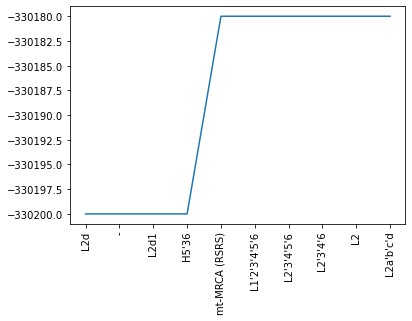

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)


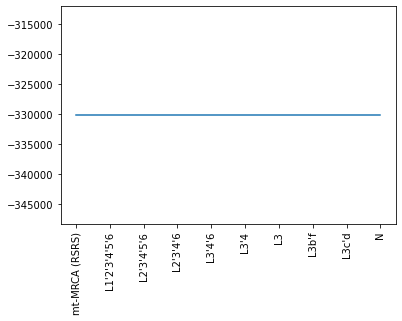

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


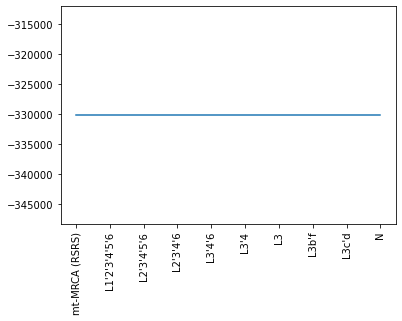

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)


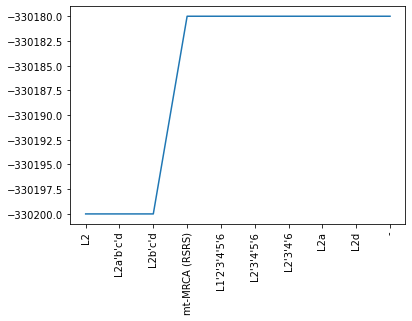

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


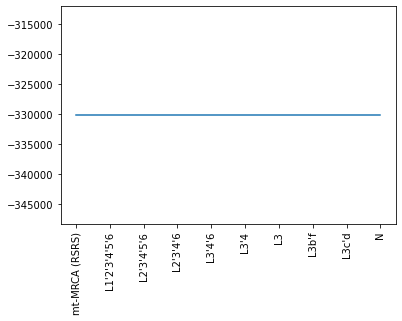

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


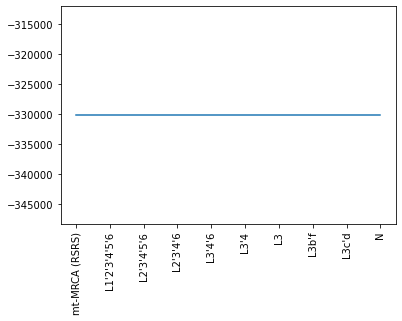

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


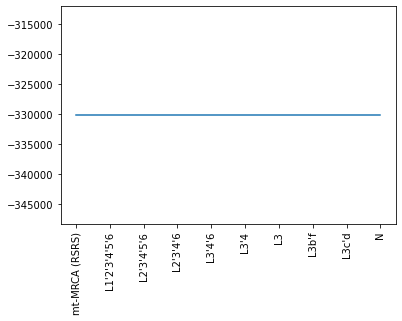

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


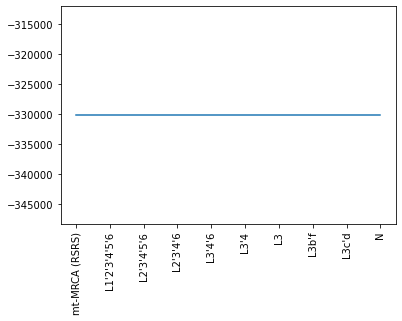

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


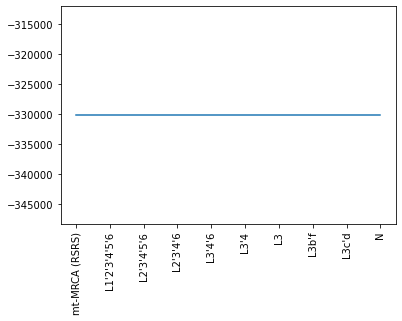

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


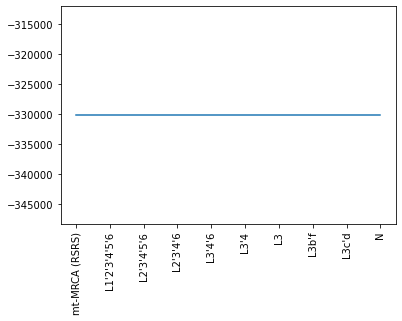

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


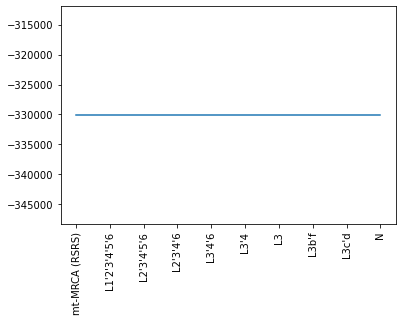

/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:19: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][2] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:15: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][0] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:17: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][1] = max(np.log10(1 - 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:21: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][3] = max(np.log10(1- 10**(-pls[k]/10)),-20)
/var/folders/6l/0qdfm_q1033f77sclr7_5nrm0000gn/T/ipykernel_59252/2194896529.py:25: RuntimeWarning: divide by zero encountered in log10
  gls[pos-1][j] = max(np.log10(1- 10**(-pls[k]/10)),-20)


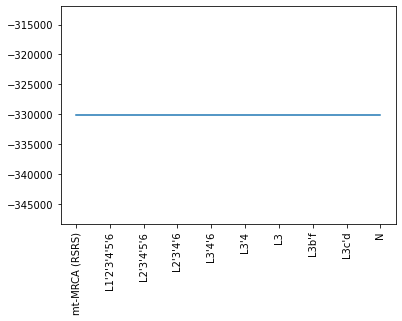

In [90]:
for i in range(12):
    v = glhap(f"gargammel{i+1}.vcf", False)
    x = [s[0] for s in v]
    y = np.array([s[1] for s in v])
    plt.plot(x, y)
    plt.xticks(rotation=90)
    plt.savefig(f'gargammel{i+1}')
    plt.show()

<BarContainer object of 10 artists>

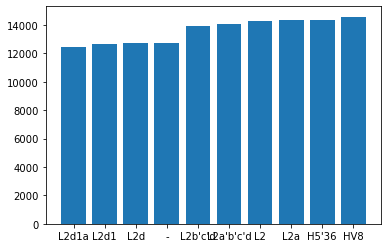

In [207]:
plt.bar(x,y)

In [208]:
glhap("gargammel12.vcf")

mt-MRCA (RSRS),lh =  14941
L1'2'3'4'5'6,lh =  14941
L2'3'4'5'6,lh =  14941
L2'3'4'6,lh =  14941
L3'4'6,lh =  14941
L3'4,lh =  14941
L3,lh =  14941
L3b'f,lh =  14941
L3c'd,lh =  14941
N,lh =  14941
14941


[('mt-MRCA (RSRS)', 14941),
 ("L1'2'3'4'5'6", 14941),
 ("L2'3'4'5'6", 14941),
 ("L2'3'4'6", 14941),
 ("L3'4'6", 14941),
 ("L3'4", 14941),
 ('L3', 14941),
 ("L3b'f", 14941),
 ("L3c'd", 14941),
 ('N', 14941)]

In [62]:
glhap("vcf/in2.vcf.gz")

N1b1a2,lh =  5019
N1b1a,lh =  5274
N1b1a2a,lh =  5274
-,lh =  5274
-,lh =  5274
N1b1a1,lh =  5529
N1b1a3,lh =  5529
N1b1a5,lh =  5529
N1b1a7,lh =  5529
N1b1a8,lh =  5529
9312


[('N1b1a2', 5019),
 ('N1b1a', 5274),
 ('N1b1a2a', 5274),
 ('-', 5274),
 ('-', 5274),
 ('N1b1a1', 5529),
 ('N1b1a3', 5529),
 ('N1b1a5', 5529),
 ('N1b1a7', 5529),
 ('N1b1a8', 5529)]

In [17]:
# INSERTIONS
# insertions = []
# for rec in bcf_in.fetch():
#     if (rec.info['INDEL']== True):
# #         if len(rec.ref)== 1 and len(rec.alts[0]) == 2:
#             insertions.append([rec.pos + 1, -rec.samples.values()[0]['PL'][-1]/10])

In [18]:
# Deletions
# deletions = []
# for rec in bcf_in.fetch():
#     if (rec.info['INDEL']== True):
#         if len(rec.ref)== 2 and rec.ref[-1]!='N' and len(rec.alts[0]) == 1:
#             deletions.append([rec.pos + 1, -rec.samples.values()[0]['PL'][-1]/10])

In [ ]:
for i in range(1,12):
    print(f'file: in{i}.vcf.gz')
    glhap(f"vcf/in{i}.vcf.gz")
    print()

In [20]:
def glhap_aposterior(bcf_in_str):
    with open('array/array.json') as f:
        d = json.load(f) # d - это список python
    for i in d:
        i[0] += 1
    d[0][0]=0

    bcf_in = VariantFile(bcf_in_str) 
    ref = FastaFile('refchrm.fa')
    a = Node(d[0][1],[])
    make_tree(d,a,0)
    ref_lh = calculate_likelihood(bcf_in, ref)
    gls = get_log_monozygous(bcf_in)
    prunung(a, ref, ref_lh, gls)
    key = lambda x: x.lh
    S = list()
    for i in PreOrderIter(a):
        S.append(i)
    S.sort(key = key,reverse=True)
    
    aposterior_divisor = sum([2**S[i].lh for i in range(len(S))])
    
    return [2**S[i].lh/aposterior_divisor for i in range(10)]
    


In [28]:
glhap(f"cov2.vcf")

A,lh =  -160.2000000000089
-,lh =  -160.2000000000089
-,lh =  -164.4000000000089
-,lh =  -164.4000000000089
A8,lh =  -166.4000000000089
A21,lh =  -168.9000000000089
A1,lh =  -170.4000000000089
A25,lh =  -170.4000000000089
A8a,lh =  -172.4000000000089
-,lh =  -175.4000000000089


In [203]:
import matplotlib.pyplot as plt

<BarContainer object of 2 artists>

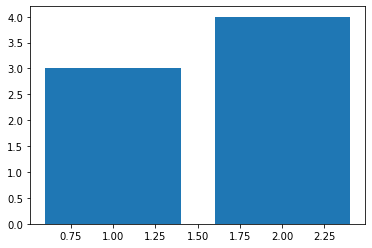

In [75]:
plt.bar([1,2],[3,4])

Это надо хитрее сделать, нужно меньше глубину покрытия сделать, тогда будет что-то похожее на правду

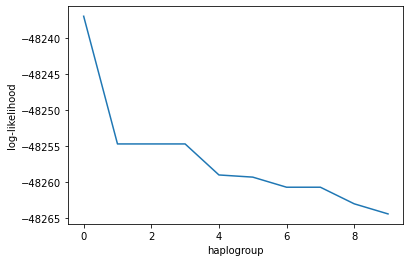

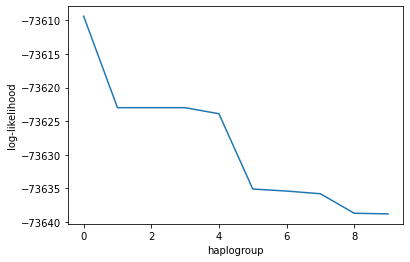

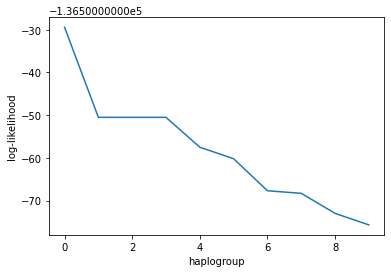

In [84]:
plt.plot([x[1] for x in s3])
plt.xlabel('haplogroup')
plt.ylabel('log-likelihood')
plt.show()
# plt.savefig('cov3')
plt.plot([x[1] for x in s5])
plt.xlabel('haplogroup')
plt.ylabel('log-likelihood')
plt.show()
# plt.savefig('cov5')
plt.plot([x[1] for x in s10])
plt.xlabel('haplogroup')
plt.ylabel('log-likelihood')
plt.show();
# plt.savefig('cov10')